In [ ]:

from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphNorm
from torch import nn
import torch
import torch.nn.functional as F
from unicodedata import category

from models import GraphClassifier
from torch.utils.checkpoint import checkpoint
from torch_geometric.data import Data, DataLoader

device = torch.device('cpu')

dataset = torch.load('../Brisbane-random.pt', weights_only=False)
train_loader = DataLoader(dataset, batch_size=64, shuffle=False)

dim = 41


hidden_dim = 64
heads = 4
numUnit1 = 1024
numUnit2 = numUnit1
numUnit3 = numUnit2
numGCN = 3
activation = 'elu'

# Initialize the model for classification and move it to the device
modelFinal = GraphClassifier(
        in_feats = dim,
        hidden_dim = hidden_dim,
        heads = heads,
        num_gcn_layers = numGCN,
        mlp_units = [numUnit1, numUnit2, numUnit3],
        mlp_activation=F.leaky_relu,
        final_activation=F.elu,
        ).to(device)

state_dict = torch.load(f'model_gnn_GAT_{numGCN}GCN_3FFNN_{hidden_dim}_{heads}_{numUnit1}_{numUnit2}_{numUnit3}.pth', map_location=torch.device('cpu'), weights_only=False)

#print(f'GAT_1GCN_2FFNN-elu/model_gnn_GAT_1GCN_2FFNN_test_{hidden_dim}_{heads}_{numUnit1}_{numUnit2}_{numUnit3}.pth')
modelFinal.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '../../Brisbane.pt'

In [2]:
import numpy as np  
pred_list = []
actual_list = []
category_list = []
num_qubits_list = []
depth_list = []

modelFinal.eval()
with torch.no_grad():
    for batch in train_loader:
        # Forward pass to get predictions and convert them to numpy arrays.
        pred_batch = torch.clamp(modelFinal(batch), min=0, max=1).detach().cpu().numpy()
        # clamp the predictions to be between 0 and 1
        
        actual_batch = batch.y.detach().cpu().numpy()
        categories = batch.category
        num_qubits = batch.num_qubits.detach().cpu().numpy()
        depth = batch.depth.detach().cpu().numpy()
        # Append the results to the lists.
        pred_list.append(pred_batch)
        actual_list.append(actual_batch)
        category_list.append(categories)
        num_qubits_list.append(num_qubits)
        depth_list.append(depth)
# Concatenate all predictions and actual values along the first axis.
pred = np.concatenate(pred_list, axis=0)
actual = np.concatenate(actual_list, axis=0)
num_qubits = np.concatenate(num_qubits_list, axis=0)
depth = np.concatenate(depth_list, axis=0)
categories= np.concatenate(category_list, axis=0)




In [3]:
categories

array(['circuit', 'circuit', 'circuit', 'circuit'], dtype='<U7')

In [4]:
num_qubits

array([4, 4, 5, 6])

In [5]:
import pandas as pd
df = pd.DataFrame({
    'pred':       pred,
    'actual':     actual,
    'num_qubits': num_qubits,
    'depth':      depth,
    'categories': categories
})

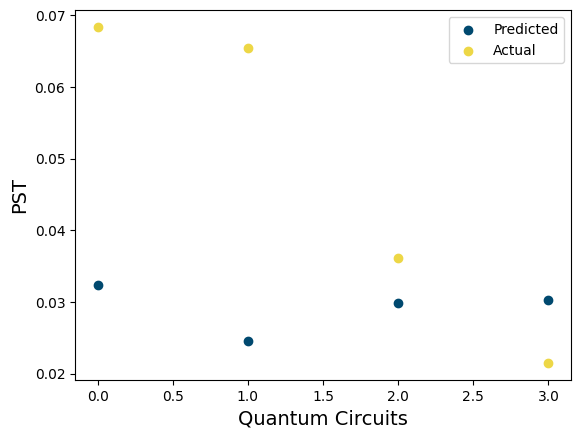

In [6]:
import matplotlib.pyplot as plt
from pypalettes import load_cmap
cmap = load_cmap("Bay")
palette = cmap.colors
# number of discrete colors in the colormap
n = cmap.N

# generate n evenly spaced floats in [0,1]
stops = np.linspace(0, 1, n)

# sample the map
palette = [cmap(s) for s in stops]

color_predicted = palette[0]
color_actual    = palette[2]
# …then plot exactly as above…

plt.scatter(np.arange(len(pred)), pred, label='Predicted', color=color_predicted)
plt.scatter(np.arange(len(actual)), actual, label='Actual', color=color_actual)
plt.xlabel('Quantum Circuits', fontsize=14)
plt.ylabel('PST', fontsize=14)
plt.legend()

plt.savefig('actual_pred_plot_bestModel_Brisbane.pdf', format='pdf', bbox_inches='tight')

In [7]:
# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0007710566860623658


In [8]:
from sklearn.metrics import r2_score

r2 = r2_score(actual, pred)
print(f"R^2 = {r2:.4f}")


R^2 = -0.9744


In [9]:
np.sqrt(1/ len(actual) * np.sum((actual - pred) ** 2)) * 100


2.776790748440303

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from typing import Callable, List, Optional

class GraphClassifier_TSNE(nn.Module):
    def __init__(
        self,
        in_feats: int,
        hidden_dim: int,
        heads: int,
        num_gcn_layers: int,
        mlp_units: List[int],
        *,
        conv_activation: Callable = F.leaky_relu,
        conv_act_kwargs: Optional[dict] = None,
        mlp_activation: Callable = F.leaky_relu,
        mlp_act_kwargs: Optional[dict] = None,
        final_activation: Callable = torch.sigmoid
    ):
        """
        A flexible GAT+GCN+MLP graph classification model.

        Args:
          in_feats:        dimensionality of node features
          hidden_dim:      each GAT head’s output size
          heads:           number of attention heads in the GAT layer
          num_gcn_layers:  how many GCNConv layers (with residuals) to stack after the GAT
          mlp_units:       list of hidden‐layer sizes for the final MLP
          conv_activation: activation fn after each graph layer
          conv_act_kwargs: extra kwargs for conv_activation
          mlp_activation:  activation fn in the MLP head
          mlp_act_kwargs:  extra kwargs for mlp_activation
          final_activation: activation applied to the final scalar output
        """
        super().__init__()
        self.conv_activation = conv_activation
        self.conv_act_kwargs = conv_act_kwargs or {}
        self.mlp_activation = mlp_activation
        self.mlp_act_kwargs = mlp_act_kwargs or {}
        self.final_activation = final_activation

        # --- GRAPH ENCODER ---
        self.convs = nn.ModuleList()
        # 1) GAT
        self.convs.append(GATConv(in_feats, hidden_dim, heads=heads))
        # 2) stack of GCNs, all dims = hidden_dim * heads
        gcn_dim = hidden_dim * heads
        for _ in range(num_gcn_layers):
            self.convs.append(GCNConv(gcn_dim, gcn_dim))

        # --- MLP HEAD ---
        self.fcs = nn.ModuleList()
        last_dim = gcn_dim
        for out_dim in mlp_units:
            self.fcs.append(nn.Linear(last_dim, out_dim))
            last_dim = out_dim

        # final linear → scalar
        self.out = nn.Linear(last_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.X, data.edge_index, data.batch
        #print(f"Input shape: {x.shape}, Edge index shape: {edge_index.shape}, Batch shape: {batch.shape}")
        # 1) Graph stack with residuals
        for i, conv in enumerate(self.convs):
            x_new = conv(x, edge_index)
            x_new = self.conv_activation(x_new, **self.conv_act_kwargs)
            x = x_new if i == 0 else x + x_new

        # 2) Global pooling
        x = global_mean_pool(x, batch)
        z = x.clone()
        # 3) MLP head
        for fc in self.fcs:
            x = self.mlp_activation(fc(x), **self.mlp_act_kwargs)

        # 4) Final scalar + final_activation
        x = self.out(x).view(-1)
        return self.final_activation(x), z
    



In [14]:

from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphNorm
from torch import nn
import torch
import torch.nn.functional as F
from models import GraphClassifier
from torch.utils.checkpoint import checkpoint
from torch_geometric.data import Data, DataLoader

device = torch.device('cpu')

dataset = torch.load('../../Brisbane.pt', weights_only=False)
train_loader = DataLoader(dataset, batch_size=64, shuffle=False)

dim = 41


hidden_dim = 64
heads = 4
numUnit1 = 1024
numUnit2 = numUnit1
numUnit3 = numUnit2
numGCN = 3
activation = 'elu'

# Initialize the model for classification and move it to the device
modelFinal = GraphClassifier_TSNE(
        in_feats = dim,
        hidden_dim = hidden_dim,
        heads = heads,
        num_gcn_layers = numGCN,
        mlp_units = [numUnit1, numUnit2, numUnit3],
        mlp_activation=F.leaky_relu,
        final_activation=F.elu,
        ).to(device)

state_dict = torch.load(f'model_gnn_GAT_{numGCN}GCN_3FFNN_{hidden_dim}_{heads}_{numUnit1}_{numUnit2}_{numUnit3}.pth', map_location=torch.device('cpu'), weights_only=False)
#print(f'GAT_1GCN_2FFNN-elu/model_gnn_GAT_1GCN_2FFNN_test_{hidden_dim}_{heads}_{numUnit1}_{numUnit2}_{numUnit3}.pth')
modelFinal.load_state_dict(state_dict)

# 2) Inference loop: collect *all* zs and ys
output_tsne_list, actual_list = [], []
modelFinal.eval()
with torch.no_grad():
    for batch in train_loader:
        preds, z = modelFinal(batch)
        output_tsne_list.append(z.cpu().numpy())
        actual_list.append(batch.y.cpu().numpy())

all_embeddings = np.concatenate(output_tsne_list, axis=0)
all_targets    = np.concatenate(actual_list,    axis=0)

# 3) (Optional) PCA → TSNE
from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE

pca = PCA(n_components=min(50, all_embeddings.shape[1]), random_state=0)
reduced = pca.fit_transform(all_embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_embedded = tsne.fit_transform(reduced)

# 4) Plot





/home/vlsigroup/miniconda3/envs/quaptor/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


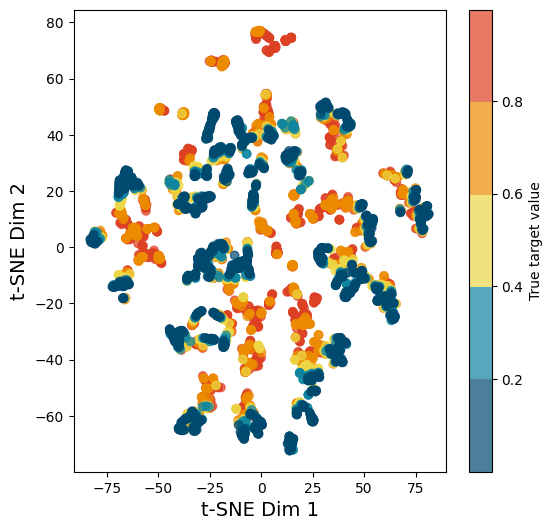

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from pypalettes import load_cmap

# Load your custom palette
cmap    = load_cmap("Bay")
palette = cmap.colors

# Create the TSNE scatter with the palette
plt.figure(figsize=(6, 6))
sc = plt.scatter(
    X_embedded[:, 0],
    X_embedded[:, 1],
    c=all_targets,
    cmap=ListedColormap(palette),
    alpha=0.7
)
plt.colorbar(sc, label="True target value")
#plt.title("t-SNE of GNN graph embeddings")
plt.xlabel("t-SNE Dim 1", fontsize=14)
plt.ylabel("t-SNE Dim 2", fontsize=14)

# Save to PDF
plt.savefig("tsne_plot_bestModel_Brisbane.pdf", format="pdf", bbox_inches="tight")



In [16]:
df

,pred,actual,num_qubits,depth,categories
0,0.978122,0.996094,2,3,grover-v-chain
1,0.973106,0.995117,2,4,grover-noancilla
2,0.978122,0.995117,2,3,grover-noancilla
3,0.973386,0.994141,2,4,grover-noancilla
4,0.973106,0.994141,2,4,grover-v-chain
...,...,...,...,...,...
4262,0.006604,0.000977,10,47,portfolioqaoa
4263,0.003292,0.000977,10,54,realamprandom
4264,0.010348,0.000977,10,218,portfoliovqe
4265,0.000547,0.000977,10,46,portfolioqaoa


In [17]:
df['Absolute Error'] = np.abs(df['pred'] - df['actual'])

/tmp/ipykernel_510183/2656617995.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories', y='Absolute Error', data=df, palette=palette)
/tmp/ipykernel_510183/2656617995.py:3: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='categories', y='Absolute Error', data=df, palette=palette)


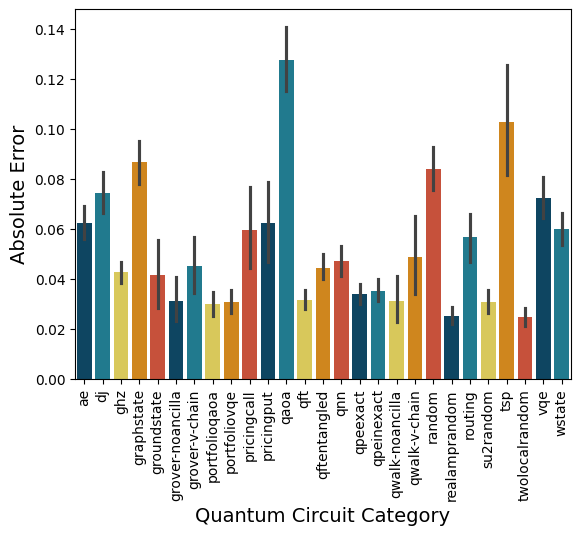

In [18]:
import seaborn as sns
df.sort_values(by='categories', inplace=True)
sns.barplot(x='categories', y='Absolute Error', data=df, palette=palette)
plt.xticks(rotation=90)
plt.xlabel('Quantum Circuit Category', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.savefig('absolute_error_per_category_bestModel_Brisbane.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_510183/3450719503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories', y='actual', data=df, palette=palette)
/tmp/ipykernel_510183/3450719503.py:2: UserWarning: 
The palette list has fewer values (5) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='categories', y='actual', data=df, palette=palette)


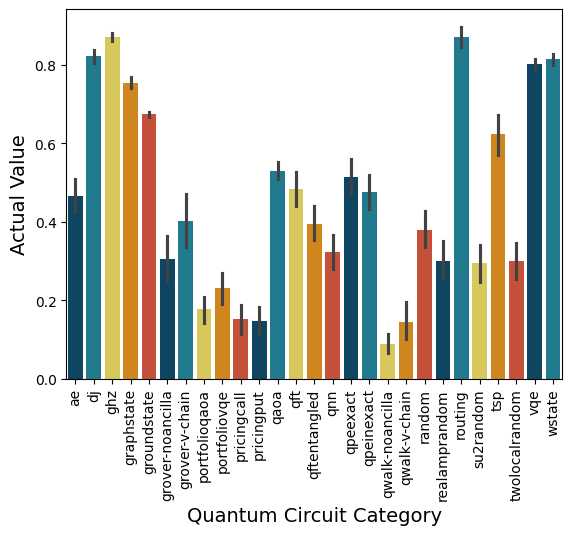

In [19]:
import seaborn as sns
sns.barplot(x='categories', y='actual', data=df, palette=palette)
plt.xticks(rotation=90)
plt.xlabel('Quantum Circuit Category', fontsize=14)
plt.ylabel('Actual Value', fontsize=14)
plt.savefig('actual_value_per_category_bestModel_Brisbane.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_510183/320793796.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_qubits', y='Absolute Error', data=df, palette=palette)
/tmp/ipykernel_510183/320793796.py:3: UserWarning: 
The palette list has fewer values (5) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='num_qubits', y='Absolute Error', data=df, palette=palette)


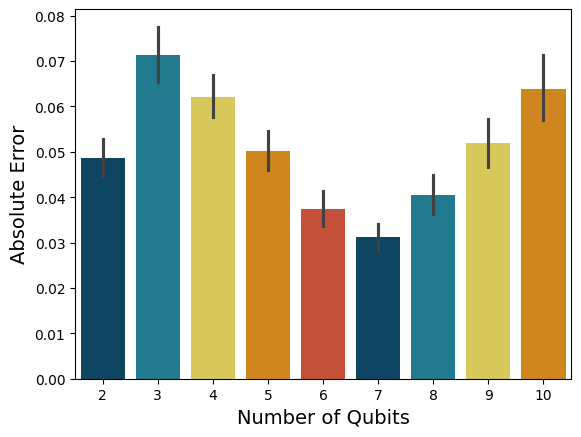

In [20]:
import seaborn as sns
df.sort_values(by='num_qubits', inplace=True)
sns.barplot(x='num_qubits', y='Absolute Error', data=df, palette=palette)
plt.xlabel('Number of Qubits', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.savefig('absolute_error_per_num_qubits_bestModel_Brisbane.pdf', format='pdf', bbox_inches='tight')
#plt.xticks(rotation=90)

/tmp/ipykernel_510183/2424176593.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='depth', y='Absolute Error', data=df, palette=palette)


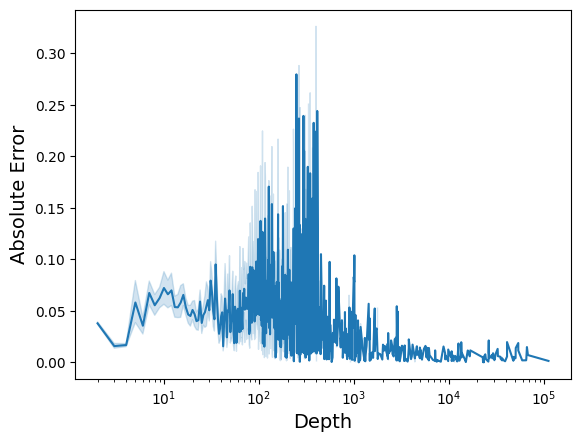

In [21]:
import seaborn as sns
sns.lineplot(x='depth', y='Absolute Error', data=df, palette=palette)
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.xscale('log')
#plt.yscale('log')
plt.savefig('absolute_error_per_depth_bestModel_Brisbane.pdf', format='pdf', bbox_inches='tight')

In [22]:
df['depth'].sort_values().unique()

array([     2,      3,      4,      5,      6,      7,      8,      9,
           10,     11,     12,     13,     14,     15,     16,     17,
           18,     19,     20,     21,     22,     23,     24,     25,
           26,     27,     28,     29,     30,     31,     32,     33,
           34,     35,     36,     37,     38,     39,     40,     41,
           42,     43,     44,     45,     46,     47,     48,     49,
           50,     51,     52,     53,     54,     55,     56,     57,
           58,     59,     60,     61,     62,     63,     64,     65,
           66,     67,     68,     69,     70,     71,     72,     73,
           74,     75,     76,     77,     78,     79,     80,     81,
           82,     83,     84,     85,     86,     87,     88,     89,
           90,     91,     92,     93,     94,     95,     96,     97,
           98,     99,    100,    101,    102,    103,    104,    105,
          106,    107,    108,    109,    110,    111,    112,    113,
      

/tmp/ipykernel_510183/3362286851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_qubits', y='actual', data=df, palette=palette)
/tmp/ipykernel_510183/3362286851.py:3: UserWarning: 
The palette list has fewer values (5) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='num_qubits', y='actual', data=df, palette=palette)


<Axes: xlabel='num_qubits', ylabel='actual'>

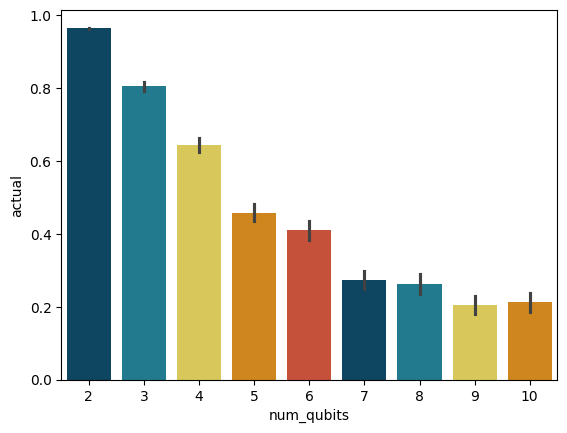

In [23]:
import seaborn as sns
df.sort_values(by='num_qubits', inplace=True)
sns.barplot(x='num_qubits', y='actual', data=df, palette=palette)